In [163]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [164]:
# This script will parse a CSV file taken from the Spectre Simulations and extract out the Early Voltage
import os
import sys
from scipy.optimize import leastsq, minimize
from numpy.ma import *
from pylab import *
import csv
import mpld3
from IPython.display import Image
from ipywidgets import interact, interactive, FloatSlider, Dropdown

This notebook will be used to extract various transistor properties from simulation, based on the EKV and UTSOI models, as opposed to the All-Region MOSFET Model described in Schneider and Galup-Montoro's book.  As such, the parameters are with reference to how EKV, and Poiroux et al. define them.

# General functions

In [165]:
# This function reads a csv file and returns the raw data from the file,
# excluding the first line.  It will return the raw data as two lists: the first
# list will have the xVals, and the second array will have the yVals.
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    xVals = data[:,0::2]
    yVals = data[:,1::2]
    return xVals, yVals

# A function that allows the end-user to specify the type of plot he/she wants 
# to retrieve by various parameters.  Essentially, this is a wrapper on the 
# readFile function above.
def getData(folderRoot, FETType="NFET_eg1L", CurveType="IdsVgs", IDVal="_Vds0.1", printFN=False):
    fN = folderRoot + FETType + "_" + CurveType + "_" + IDVal + ".csv"
    if printFN:
        print fN
    xVals, yVals = readFile(fN)
    return xVals, yVals

# UT calculates the thermal voltage as a function of temperature (in Celsius), the value of
# electronic charge, and Boltzmann's constant.
def UT(degC):
    _k = 1.3806503e-23
    _q = 1.60217646e-19
    return(_k*(273.15+degC)/_q)

## Fitting algorithm functions

In [166]:
# fitLine takes data organized as columns of x,y pairs of data, and sorts through the columns to fit a line to each
# column's worth of data.  It returns an array for each output variable, m and b.  Each output array is of length = 
# number of columns
def fitLine(data, mGuess=0.00002, bGuess=0.00005):
    Xs, Ys = data
    ms = list()
    bs = list()
    if len(shape(Ys))>1:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            popt,pcov = leastsq(linFitErr, (mGuess, bGuess), args=(Xs, Ys.T[i]))
            #print popt
            ms.append(popt[0])
            bs.append(popt[1])
    else:
        popt,pcov = leastsq(linFitErr, (mGuess, bGuess), args=(Xs, Ys))
        #print popt
        ms.append(popt[0])
        bs.append(popt[1])

    return array(ms), array(bs)

# linFit gets plots a line with slope m, and y-intercept b
def linFit(x, m, b):
    return m*x + b

# linFitErr calculates the difference between some data and a theoretical line with slope m, and
# y-intercept b.
def linFitErr(x0s, xData, yData):
    (m,b) = x0s
    return yData - linFit(xData, m, b)

# Fits the slope factor to extract gamma (the body-effect coefficient) and phi_F (Fermi Potential)
def SFParamEq(xData, gamma, phiF):
    invNOffsetSq = (4./(gamma**2))*(xData + (2.*phiF))
    return invNOffsetSq

# This function returns the residual to fitting the slope factor equation
# (as a function of gamma and phiF)
def SFParamEq_res(params, yData, xData):
    gamma, phiF = params
    err = yData - SFParamEq(xData, gamma, phiF)
    return err

# getEarlyVoltages finds the slope and y-intercept of the line that best fits the data
# for x-values above "threshold"
def getEarlyVoltages(origVds, origIds, threshold):
    mask = origVds>threshold
    if len(mask)<1:
        print "WARNING: Threshold might be set too high"
    ev_Vds = origVds[mask]
    ev_Ids = origIds[mask]
    
    Ms, Bs = fitLine((ev_Vds,ev_Ids))
    EarlyVoltages = calcEV(Ms, Bs)
    print "Early Voltages:\t", EarlyVoltages
    
    return (ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs)

# calcEV takes the slope and y-intercept of a line and uses that to calculate the x-intercept.
# This allows the user to fit a linear line and calculate the Early Voltage from that.
def calcEV(m, b):
    return -b/m

## List-based functions
These functions are operations that need to be performed on lists

In [167]:
def elementWiseAvg(lst):
    avglst = array([((lst[i]+lst[i+1])/2.) for i, curElement in enumerate(lst[:-1])])
    #print "AVG list: ", avglst
    return avglst

def rejectOutliers(data, m = 2.):
    dat = array(data)
    d = np.abs(dat - np.median(dat))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    #print d, '\n',mdev,'\n', s, '\n', map(int, round(s)), '\n', s<m
    return dat[s<m], s<m
#def rejectOutliers(data, m=2):
    #return data[abs(data - np.mean(data)) < m * np.std(data)]

## Plotting functions
### General plotting functions

In [179]:
def setAxis(ax=None):
    # If no axis is explicitly sent, use the current axis
    if ax==None:
        curAxis = gca()
        #print "No Axis found using current axis in memory", curAxis
    else:
        curAxis = ax
        sca(ax)
    #sca(curAxis)
    return curAxis
        
def setXLim(Xs, xLims=None, minScale=0.9, maxScale=1.1, ax=None):
    setAxis(ax)
    sca(ax)
    if type(xLims)==str:
        if xLims=="N":
            xlim(Xs.min()*minScale, 0)
        elif xLims=="P":
            xlim(0, Xs.max()*maxScale)
        elif xLims=='NP' or xLims=='PN':
            xlim(Xs.min()*minScale, Xs.max()*maxScale)
    elif type(xLims)==tuple:
        xlim(xLims)

def setYLim(Ys, yLims=None, minScale=0.9, maxScale=1.1, ax=None):
    setAxis(ax)
    sca(ax)
    if type(yLims)==str:
        if yLims=="N":
            ylim(Ys.min()*minScale, 0)
        elif yLims=="P":
            ylim(0, Ys.max()*maxScale)
        elif yLims=='NP' or yLims=='PN':
            ylim(Ys.min()*minScale, Ys.max()*maxScale)
    elif type(yLims)==tuple:
        ylim(yLims)

def plotXY(Xs, Ys, ttl="Y vs X", marker='.', xLbl="X", yLbl="Y",
           color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        ax.plot(Xs, Ys, marker=marker, color=color)
    else:
        print "multiple columns"
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.plot(Xs, Ys.T[i], marker=marker, color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.9, maxScale=1.1, ax=ax)
    setYLim(Ys, yLims, minScale=0.9, maxScale=1.1, ax=ax)
    title(ttl, fontsize=fntSz-4)

def plotXlogY(Xs, Ys, ttl="Log[Y] vs X", marker='.', xLbl="X", yLbl="Log[Y]",
              color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        ax.semilogy(Xs, Ys, marker=marker, color=color)
    else:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.semilogy(Xs, Ys.T[i], marker=marker, color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.1, maxScale=10, ax=ax)
    setYLim(Ys, yLims, minScale=0.1, maxScale=10, ax=ax)
    title(ttl, fontsize=fntSz-4)

def plotlogXlogY(Xs, Ys, ttl="Log[Y] vs Log[X]", marker='.', xLbl="Log[X]", yLbl="Log[Y]",
              color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        ax.loglog(Xs, Ys, marker=marker, color=color)
    else:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.loglog(Xs, Ys.T[i], marker=marker, color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.1, maxScale=10, ax=ax)
    setYLim(Ys, yLims, minScale=0.1, maxScale=10, ax=ax)
    title(ttl, fontsize=fntSz-4)

# This function plots the derivative of any data set.
def plotDeriv(Xs, Ys, ttl="dY vs X", marker='.', xLbl='X', yLbl='dY',
              color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    setAxis(ax)
    dYs = diff(Ys)
    dXs = diff(Xs)
    ax.plot(Xs[:-1], dYs/dXs, marker=marker, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.9, maxScale=1.1, ax=ax)
    setYLim(dYs, yLims, minScale=0.9, maxScale=1.1, ax=ax)
    title(ttl, fontsize=fntSz-4)
    return dYs/dXs

# Plot a histogram of the gmOverId values to see what value I should be using for my maximum
def plotHist(Xs, numBins=100, ttl=r'$Histogram$', color=(1,0,0),
             xLbl=r'Xs', yLbl=r'Count', fntSz=16, ax=None):
    setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Xs))<=1:
        ax.hist(Xs, bins=numBins, color=color, alpha=0.5, histtype="stepfilled")
    else:
        numCols = shape(Xs)[1]
        for i in range(numCols):
            ax.hist(Xs.T[i], bins=numBins,
                    color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))), alpha=0.5,
                    histtype="stepfilled")
    (cnts, binBoundaries) = histogram(Xs, numBins)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    ylim([cnts.min(), cnts.max()*1.1])
    title(ttl)
    return cnts, binBoundaries

### $V_{gs}$ based functions
This sections includes plotting functions for transconductance as well.

In [169]:
def plotVgPlots(Vgs, Ids, ttl, marker='.', color=(1,0,0), fntSz=16):
    gms = calcGm(Vgs, Ids)
    #print "gms", gms
    gmOverId = calcGmOverId(gms, elementWiseAvg(Ids))
    #print "gm/Id", gmOverId
    #gmOverId = calcGmOverId_Vgs(Vgs, Ids)
    #print "gm/Id", gmOverId
    
    Vth, half_gmOverId = calcVth(Vgs[:-1], gmOverId)
    #print "Cur Vth:", Vth
    ISVal = calcIS(Vth, Vgs, Ids)
    #print "Cur Is:", ISVal
    
    ax1 = subplot(1,3,1)
    plotXlogY(Vgs, Ids, ttl=ttl, xLbl=r'$V_{gs}$', yLbl=r'$I_{ds}$', 
              marker=marker, color=color, ax=ax1)
    # Use the threshold voltage calculated to plot a vertical line in the plot
    vlines(Vth, Ids.min()/10, Ids.max()*10,
           colors=color,
           linestyles='dashed')

    ax2 = subplot(1,3,2)
    plotXlogY(Vgs[:-1], gms, ttl=r'$g_m$ '+ttl,
              xLbl=r'$V_{gs}$', yLbl=r'$|g_m|$', marker=marker, color=color, ax=ax2)
     
    ax3 = subplot(1,3,3)
    plotXY(Vgs[:-1], gmOverId, ttl=r'$g_m/I_{ds}$ '+ttl,
           xLbl=r'$V_{gs}$', yLbl=r'$g_m/I_{ds}$', marker=marker, color=color, ax=ax3)
    # Use the threshold voltage calculated to plot a vertical line in the plot
    hlines(half_gmOverId, 0, 1,
           colors=color,
           linestyles='dashed')
    vlines(Vth, gmOverId.min()/1.1, gmOverId.max()*1.1,
           colors=color,
           linestyles='dashed')

    tight_layout()

    return Vth, ISVal, gms, gmOverId

# Plot a histogram of the gmOverId values to see what value I should be using for my maximum
def plotGmOverIdHist(gmOverIds, numBins=100, ttl=r'$g_m/I_d Histogram$', color=(1,0,0), fntSz=16):
    plotHist(gmOverIds, numBins=numBins, ttl=ttl, color=color, xLbl=r'$g_m/I_d$')
    avgMaxGmOverId, cnts = calcAvgMaxGmOverId(gmOverIds, numBins)   
    # Use the threshold voltage calculated to plot a vertical line in the plot
    vlines(max(gmOverIds), cnts.min(), cnts.max()*1.1,
           colors=color,
           linestyles='dotted')
    vlines(avgMaxGmOverId, cnts.min(), cnts.max()*1.1,
           colors=color,
           linestyles='dashed')
    return avgMaxGmOverId

### Slope-factor based plots

In [170]:
def plotVpvsVg(Xs, Ys, ttl="", marker='', color=(1,0,0), fntSz=16):
    return plotXY(Xs, Ys, ttl=ttl, marker=marker, 
                  xLbl=r'$V_{p} (V_s)$', yLbl=r'$V_{g}$', color=color)
    
# This function plots the derivative of the VpvsVg plot above.  As such, it gives
# the slopefactor as a function of Vp.
def plotSlopeFactor(Xs, Ys, ttl="", marker='.',color=(1,0,0), fntSz=16):
    return plotDeriv(Xs, Ys, ttl=ttl, marker=marker, color=color, 
              fntSz=fntSz, xLbl=r'$V_{p} (V_s)$', yLbl=r'$n (1/\kappa)$')
    

# This function plots the slope factor (n) as a function of Vgb-Vs (Vgbs)
# It allows one to intuit how the slopefactor is changing for a given back-gate
# voltage, as per some of the analogies in the Trivedi '06 paper.
def plotSFvsVgbs(Xs, Ys, ttl="", marker='', color=(1,0,0), fntSz=16):
    return plotXY(Xs, Ys, ttl=ttl, marker=marker, xLbl=r'$V_{gbs}$', yLbl=r'$n$',
                  color=color)

# This function plots the 1/(n-1)^2 data vs Vps
# Input to this function are two arrays, Vps and Ns
def plotSFParamData(Xs, Ns, ttl="", marker='.', color=(1,0,0), fntSz=16):
    Ys = calcInvNOffSq(Ns)
    
    plotXY(Xs,Ys, ttl=ttl, marker=marker,
           xLbl=r'$V_{p} (V_s)$', yLbl=r'$1/(n-1)^2$', color=color)
    return Ys

## Extraction functions

### Helper calculator functions

In [171]:
# calculate transcondutance if given two arrays, Vg values and Id Values, respectively
# Note: if the arrays are multidimensional, they should be arranged so that each
#     row corresponds to the array of Vg or Id values, respectively.
def calcGm(Vgs, Ids):
    return abs(diff(Ids))/diff(Vgs)

# Takes Vgs and Ids and returns an array of gm/Id
# This function is an alternative to calcGmOverId below
#    Vgs: array of Vg values
#    Ids: array of Id values
# Note: these two arrays must be of the same size.
def calcGmOverId_Vgs(Vgs, Ids):
    return abs(diff(log(Ids)))/diff(Vgs)

# Takes gms and Ids and returns an array of gm/Id
#    gms: array of transconductances
#    Ids: array of Id values
# Note: these two arrays must be of the same size.
def calcGmOverId(gms, Ids):
    return gms/Ids

# This function takes an array of gmOverId values and a bin count and returns
#   the average maximum value of the array.  This allows us to filter out some
#   of the odd bumps and drops that happen in these plots
def calcAvgMaxGmOverId(gmOverIds, numBins=100):
    (cnts, binBoundaries) = histogram(gmOverIds, numBins)
    #print "Counts:", cnts
    #print "Bins:", binBoundaries
    mask = argmax(cnts)    # Find the index where the maximum count is first found
    #print mask, binBoundaries[mask], mask+1, binBoundaries[mask:mask+2]
    avgMaxGmOverId = mean(binBoundaries[mask:mask+2])
    #print avgMaxGmOverId
    return avgMaxGmOverId, cnts

# This function takes the gmOverId values and the Vgs values and returns Vth
#    Vgs: array of gate voltages corresponding to the gm/Id values
#    gmOverID: array of gm/Id values
def calcVth(Vgs, gmOverId):
    # Calculate the threshold voltage from the last plot's data
    #half_gmOverId = gmOverId.max(axis=0)*0.53  #from S&GM, p.462, footnote 1
    # Use the steady-state maximum value instead of the exact outlier value.
    avgMaxGmOverId, cnts = calcAvgMaxGmOverId(gmOverId, numBins=100)
    half_gmOverId = avgMaxGmOverId*0.53  #from S&GM, p.462, footnote 1
    #print "Half of max(gm/Id ratio):", half_gmOverId
    li = int(len(gmOverId)*0.15)  # Lower Index value to use to test for NFET vs PFET
    ui = int(len(gmOverId)*0.85)  # Upper Index value to use to test for NFET vs PFET
    
    #print "lower index and upper index", li, ui
    #print "gmOverId value at these indices", gmOverId[li], gmOverId[ui]
    
    if gmOverId[li]>gmOverId[ui]:   # FETType is an NFET
        Vth = Vgs[where(gmOverId>=half_gmOverId)][-1]
        #print "NFET"
    else:    # FETType is a PFET FETType=="P"
        Vth = Vgs[where(gmOverId>=half_gmOverId)][0]
        #print "PFET"
    #print "Vth: ", Vth
    return Vth, half_gmOverId
    

# This function takes a threshold voltage and two arrays as arguments
#    Vth: threshold voltage
#    Vgs: array of gate voltages corresponding to the Id values
#    Ids: array of Id values
# Returns the specific current for this transistor, at Vth.
# Note the returned value may be an array if the input Vgs and Ids values are 
# multi-dimensional (MxN) arrays.  If this is the case, end-user must be sure to
# grab the correct values that he/she wants from the result N-element long array
def calcIS(Vth, Vgs, Ids):
    
    Vth_idx = where(Vgs[:]==Vth)
    #print "Vth_idx:", Vth_idx
    #print Ids[Vth_idx], Ids[Vth_idx][0]
    IS = Ids[Vth_idx]*1.13 # from S&GM, p.462, Footnote 1
    #print "IS Val: ", IS
    return IS


# This function takes a value for n and returns 1/(n-1)^2
def calcInvNOffSq(N):
    return 1./((N-1)**2)

# This fucntion takes a value for 1/(n-1)^2 and returns n
def calcN(invNOffSq):
    return sqrt(1./invNOffSq)+1

# This function returns the derivative values for any data set
def calcDeriv(Xs, Ys):
    dYs = diff(Ys)
    dXs = diff(Xs)
    return dYs/dXs

### Helper get functions

In [172]:
# This function will take a scalar value of a drain current and return the
#   corresponding V (Vg or Vd) value for it.
#   The V Val returned is based on the curveType of the plot
# IVal: scalar
# VVals: 1D Array of voltage values
# IVals: 1D Array of current values
def getVVal(IVal, VVals, IVals):
    #print "Mean of difference: ", mean(diff(yVals[:,i]))
    if mean(diff(IVals))<0:  # implies that Ivals decrease as Vvals increase
        #print "Device is PFET"
        Vg = VVals[where(IVals<=IVal)[0][0]]
    else:
        #print "Device is NFET"
        Vg = VVals[where(IVals<=IVal)[0][-1]]
    #print Vg
    return Vg

# This function will take a scalar value of a voltage and return the
#   drain current  I value corresponding to it
# VVal: scalar value (either Vg or Vd)
# VVals: 1D Array of voltage values
# IVals: 1D Array of current values
# Note: This function assumes that VVals is always smallest to largest (sorted)
def getIVal(VVal, VVals, IVals):
    Id = IVals[where(VVals<=VVal)[0][-1]]
    #print Id
    return Id

def getMaskedVals(Xs, Ys, XLims):
    maskedXsObj = masked_outside(Xs,XLims[0],XLims[1])
    #print maskedIds
    mask = maskedXsObj.mask
    maskedXs = Xs[~mask]
    maskedYs = Ys[~mask]
    return maskedXs, maskedYs

### Extract Specific Current
These functions will plot log gm/Id vs log Id and use those plots to extract the specific current

In [191]:
def extractIS(FETTypes, folderRoot, ttl, xLims=None, yLims=None,
              lBounds=(10**-13, 10**-10), uBounds=(10**-7, 10**-5),
              curveType="IdsVgsCurve", printFN=False):
    numFETs = len(FETTypes)
    print "Number of FETTypes:", numFETs
    numTemps = len(temps)
    maxY = 0
    
    ISs = list()
    ax1 = subplot2grid((2, 6), (0, 0), colspan=3)
    ax2 = subplot2grid((2, 6), (0, 3), colspan=3)
    ax3 = subplot2grid((2, 6), (1, 0), colspan=2)
    ax4 = subplot2grid((2, 6), (1, 2), colspan=2)
    ax5 = subplot2grid((2, 6), (1, 4), colspan=2)
    
    for j, curFETType in enumerate(FETTypes):
        curISList = list()
        for i, curTemp in enumerate(temps):
            #Vd = Vds[i]
            Vd = 1
            print "FETType:", curFETType, "Temp:", curTemp, "\tVds:", Vd

            Vgs, Ids = getData(folderRoot, FETType=curFETType,
                                 CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)
            #if numFETs>1:
            col = (1.*i/(numTemps-1), 1.*j/numFETs, 1-(1.*i/(numTemps-1)))
            #else:
            #    col = (1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1)))
            
            gms = calcGm(Vgs[:,i], Ids[:,i])
            #print "gms", gms
            gmOverId = calcGmOverId(gms, elementWiseAvg(Ids[:,i]))
            #print "gm/Id", gmOverId
            gmOverIdUt = gmOverId*UT(curTemp)
            plotlogXlogY(Ids[:-1,i], gmOverIdUt, ttl=ttl, marker='',
                         xLbl=r'$I_{ds}$', yLbl=r'$g_m*\phi_t/I_{ds}$', color=col, 
                         xLims=xLims, yLims=yLims, ax=ax1)
            plotXY(log(Ids[:-1,i]), log(gmOverIdUt), ttl=ttl, marker='',
                         xLbl=r'$log(I_{ds})$', yLbl=r'$log(g_m*\phi_t/I_{ds})$', color=col, 
                         xLims=log(xLims), yLims=log(yLims), ax=ax2)
            
            IS = calcIntersectIS(log(Ids[:-1,i]),log(gmOverIdUt), 
                                 log(lBounds),log(uBounds), color=col, 
                                 ax=ax2)
            xlim(log(xLims))
            ylim(log(yLims))
            curISList.append(IS)
            
            plotXlogY(Vgs, Ids[:,i], ttl=ttl, xLbl=r'$V_{gs}$', yLbl=r'$I_{ds}$',
                      marker='', color=col, ax=ax3)
            hlines(uBounds[1], 0, max(Vgs), colors=col, linestyles='dashed')
            plotXY(Vgs, Ids[:,i], ttl=ttl, xLbl=r'$V_{gs}$', yLbl=r'$I_{ds}$',
                   marker='', color=col, ax=ax4)
            hlines(uBounds[1], 0, max(Vgs), colors=col, linestyles='dashed')
            cnts, binBoundaries = plotHist(log(Ids[:,i]), numBins=100, color=col,
                                           xLbl=r'$log(I_{ds})$', ax=ax5)           
        ISs.append(curISList)
    
    tight_layout()
    for j, curFETType in enumerate(FETTypes):
        print "IS (",curFETType,"):", ISs[j]
        for i, curTemp in enumerate(temps):
            #print UT(curTemp)**2
            print 'IS_norm(',curTemp,'):', ISs[j][i]/(UT(curTemp)**2)
    
    return ISs

# This function takes two arrays as arguments
#    Ids: 1D-array of Id values
#    gmOverIdUts: 1D-array of gm*ut/Id values
# Returns the specific current for this transistor using the intersecting point
# of the asymptotes to the gm*ut/Id vs Id plot.
def calcIntersectIS(Ids, gmOverIdUts, lowerXLims, upperXLims, color,
                    ax=None):
    setAxis(ax)
    #Linearly fit the lower the lower half of the data
    maskedXs, maskedYs = getMaskedVals(Ids, gmOverIdUts, lowerXLims)
    ax.plot(maskedXs, maskedYs, '-',color=(0,0.5,0))
    m_l, b_l = fitLine((maskedXs,maskedYs), mGuess=0, bGuess=1)
    #print m_l, b_l
    
#    # Linearly fit the upper half of the data
    maskedXs, maskedYs = getMaskedVals(Ids, gmOverIdUts, upperXLims)
    ax.plot(maskedXs, maskedYs, '-', color=(0,0.5,0))
    m_u, b_u = fitLine((maskedXs,maskedYs), mGuess=200000, bGuess=1)
    #print m_u, b_u
    
    # Plot fit lines
    XsFit = linspace(min(Ids), max(Ids), 100)
    lowYsFit = linFit(XsFit, m_l, b_l)
    uppYsFit = linFit(XsFit, m_u, b_u)
    plot(XsFit, lowYsFit, '--', color=color)
    plot(XsFit, uppYsFit, '--', color=color)
    
    # Calculate intersection point of two fit lines
    # Set this intersection point as the specific current
    a = array([[1, -m_l],
               [1, -m_u]])
    b = array([b_l, b_u])
    yx = exp(solve(a, b)).flatten()
    IS = yx[1]
    #print "log(gm*Ut/Id), log(Id):", yx
    return IS

Number of FETTypes: 3
FETType: NFET_eg1L_linSteps_vRBB-2_Vgs3 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-2_Vgs3 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-2_Vgs3 Temp: 50.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-1_Vgs3 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-1_Vgs3 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-1_Vgs3 Temp: 50.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB0_Vgs3 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB0_Vgs3 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB0_Vgs3 Temp: 50.0 	Vds: 1
IS ( NFET_eg1L_linSteps_vRBB-2_Vgs3 ): [4.2186724010114786e-07, 4.3283858173003709e-07, 4.4174624370498221e-07]
IS_norm( 0.0 ): 0.000761424246127
IS_norm( 25.0 ): 0.000655706740151
IS_norm( 50.0 ): 0.000569662792789
IS ( NFET_eg1L_linSteps_vRBB-1_Vgs3 ): [4.1351606702626272e-07, 4.2586177720837838e-07, 4.3659222811727081e-07]
IS_norm( 0.0 ): 0.00074635129175
IS_norm( 25.0 ): 0.000645137585869
IS_norm( 50.0 ): 0.000563016327866
IS ( NFET_eg1L_linStep

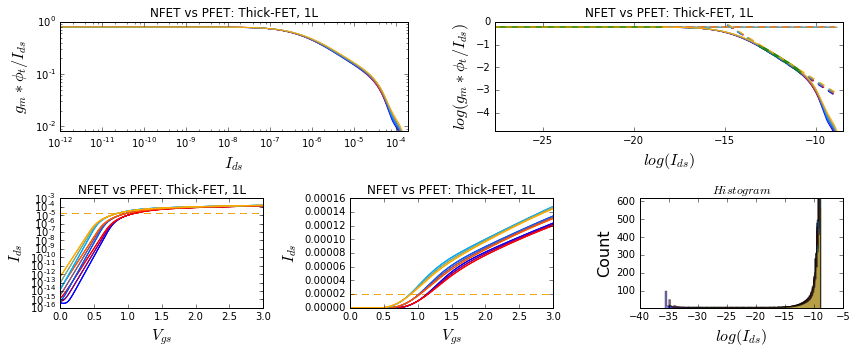

In [192]:
FETTypes = ("NFET_eg1L_linSteps_vRBB-2_Vgs3", "NFET_eg1L_linSteps_vRBB-1_Vgs3", "NFET_eg1L_linSteps_vRBB0_Vgs3")
#FETTypes = (["NFET_eg1L_logSteps_vRBB0"])
ISs = extractIS(FETTypes,
                folderRoot,"NFET vs PFET: Thick-FET, 1L", 
                xLims=(10**-12,2*10**-4), yLims=(8*10**-3,1),
                lBounds=(10**-12,10**-8), uBounds=(2*10**-6,2*10**-5),
                curveType="IdsVgsCurve")

### Compare FETs function
This function allows us to plot $V_g$ plots of one type of FET vs another

In [174]:
def compareFETs(FETTypes, folderRoots, ttl, curveType="IdsVgsCurve", printFN=False):
    FETType1, FETType2 = FETTypes
    folderRoot1, folderRoot2 = folderRoots
    
    numTemps = len(temps)
    maxY = 0
    
    Vths1 = list()
    ISs1 = list()
    Vths2 = list()
    ISs2 = list()
    
    for i, curTemp in enumerate(temps):
        Vd = Vds[i]
        #print 
        print "Temp:", curTemp, "\tVds:", Vd

        Vgs1, Ids1 = getData(folderRoot1, FETType=FETType1,
                                                CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)
        Vgs2, Ids2 = getData(folderRoot2, FETType=FETType2,
                                                CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)
        
        col1 = (1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1)))
        col2 = (1.*i/(numTemps-1), 0.5, 1-(1.*i/(numTemps-1)))
        Vth1, IS1, gms1, gmOverId1 = plotVgPlots(Vgs1[:,i], Ids1[:,i],
                                        ttl=ttl, marker='', color=col1)
        #print "Vth1:\t", Vth1, "\nIS1:\t", IS1
        Vths1.append(Vth1)
        ISs1.append(IS1[0])

        Vth2, IS2, gms2, gmOverId2 = plotVgPlots(Vgs2[:,i], Ids2[:,i],
                                        ttl=ttl, marker='', color=col2)
        #print "Vth2:\t", Vth2, "\nIS2:\t", IS2
        Vths2.append(Vth2)
        ISs2.append(IS2[0])

        maxY = max( [maxY, 1.1*max( gmOverId1.flatten() ), 1.1*max( gmOverId2.flatten() )] )
        #print "Max Y:", maxY
        ylim((0,maxY))
        
    print "Vth (",FETType1,"):", Vths1, "\nVth (",FETType2,"):", Vths2
    print "IS (",FETType1,"):", ISs1, "\nIS (",FETType2,"):",ISs2
    
    return Vths1, ISs1, Vths2, ISs2

def compareMultFETs(FETTypes, folderRoot, ttl, curveType="IdsVgsCurve", printFN=False):
    numFETs = len(FETTypes)
    numTemps = len(temps)
    maxY = 0
    
    Vths = list()
    ISs = list()
    
    for j, curFETType in enumerate(FETTypes):
        curVthList = list()
        curISList = list()
        for i, curTemp in enumerate(temps):
            Vd = Vds[i]
            #print 
            print "FETType:", curFETType, "Temp:", curTemp, "\tVds:", Vd

            Vgs, Ids = getData(folderRoot, FETType=curFETType,
                                 CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)
            if numFETs>1:
                col = (1.*i/(numTemps-1), 1.*j/(numFETs), 1-(1.*i/(numTemps-1)))
            else:
                col = (1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1)))
            Vth, IS, gms, gmOverId = plotVgPlots(Vgs[:,i], Ids[:,i], ttl=ttl, marker='',
                                                 color=col)
            #print "Vth1:\t", Vth, "\nIS1:\t", IS
            curVthList.append(Vth)
            curISList.append(IS[0])

            #maxY = max( [maxY, 1.1*max( gmOverId.flatten() ), 1.1*max( gmOverId.flatten() )] )
            #print "Max Y:", maxY
            #ylim((0,maxY))
        Vths.append(curVthList)
        ISs.append(curISList)
    
    for j, curFETType in enumerate(FETTypes):
        print "Vth (",curFETType,"):", Vths[j]
    for j, curFETType in enumerate(FETTypes):
        print "IS (",curFETType,"):", ISs[j]
        for i, curTemp in enumerate(temps):
            print 'IS_norm(',curTemp,'):', ISs[j][i]/(UT(curTemp)**2)
    
    return Vths, ISs

### Get max $g_m/I_d$ from a set of curves
This function will plot the histograms and calculate the average maximum value of $g_m/I_d$

In [175]:
def getMaxGmOverIdFunc(FETType, folderRoot, ttl, curveType="IdsVgsCurve", printFN=False, colorSkew=0):
    numTemps = len(temps)
    maxY = 0
    
    for i, curTemp in enumerate(temps):
        Vd = Vds[i]
        #print 
        print "Temp:", curTemp, "\tVds:", Vd

        Vgs, Ids = getData(folderRoot, FETType=FETType,
                                                CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)

        gms = calcGm(Vgs[:,i], Ids[:,i])
        #print "gms", gms
        gmOverId = calcGmOverId(gms, elementWiseAvg(Ids[:,i]))
        #print "gm/Id", gmOverId
        #subplot(1,numTemps,i+1)
        maxGmOverId = plotGmOverIdHist(gmOverId[gmOverId>max(gmOverId)*0.8], 200, 
                               ttl ,color=(1.*i/(numTemps-1), colorSkew, 1-(1.*i/(numTemps-1))))
        print maxGmOverId
    tight_layout()

### Slope factor functions

In [176]:
def getSFParams(Vps, invNOffSqs, p0):
    #print len(Vps), Vps
    #print len(invNOffSqs), invNOffSqs
    #Ys = 1/((Ns-1)**2)
    params = leastsq(SFParamEq_res, p0, args=(invNOffSqs, Vps))
    #print "Leastsq return values: ", params
    
    #Once we have scipy ver 18+, this following bounded least square operation will hopefully work
    #params = least_squares(SFParamEq_res, p0, args=(invNOffSqs, Vps), bounds=((-inf, inf), (-1,1)))
    #print params[0]
    gamma, phiFermi = params[0]
    #print "Fitted Gamma:", gamma, "\t Fitted V_fermi:", phiFermi
    return gamma, phiFermi

def slopeFactor(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction",
                temps=[25], ttl=None, xLims=(0,1), yLims=None, printFN=False,
                plotIdx=0, Vdd=None, Vth=None):
    numTemps = len(temps)
    SFs = list()
    gammas = list()
    vFermis = list()
    j = plotIdx
    if ttl==None:
        ttl = FETType
        
    for i, curTemp in enumerate(temps):
        #print
        #print "Temp:", curTemp
        curColor = (1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1)))

        Vps, Vgs = getData(folderRoot, FETType=FETType,
                           CurveType=curveType, IDVal="T"+str(int(curTemp))+"C", printFN=printFN)
        # Plot of pinch-off voltage vs gate voltage
        subplot(1,3,1)
        plotVpvsVg(Vps[:,j+1],Vgs[:,j+1], ttl="$V_p vs V_g$: "+ttl,
                    color=curColor, fntSz=14)
        xlim(xLims)

        # Plot of slope factor vs Vgs
        subplot(1,3,2)
        curSFs = plotSlopeFactor(Vps[:,j+1],Vgs[:,j+1], ttl="$n (1/\kappa)$: "+ttl,
                    color=curColor, fntSz=14)
            
        xlim(xLims)
        ylim(yLims)
        #print array(curSFs)
        SFs.append(array(curSFs))
        #print Vps[:-1,i]-(1/array(curSFs)*Vgs[:-1,j+1])
               
        # Plot of 1/(n-1)^2 vs Vp curve
        subplot(1,3,3)
        #print curSFs
        Ns = array(curSFs)
        if xLims!=None:
            mask = where((Vgs[:,j+1]>=min(xLims))*(Vgs[:,j+1]<max(xLims)))[0]
        else:
            mask = where((Vgs[:,j+1]>=min(Vgs[:,j+1]))*(Vgs[:,j+1]<max(Vgs[:,j+1])))[0]
            mask = mask - min(mask)
        gamma, phiFermi = getSFParams(Vgs[mask,0], calcInvNOffSq(Ns)[mask], (0.5, 0.5))
        gammas.append(gamma)
        vFermis.append(phiFermi)
        #print "Extracted Gamma, and FermiV:", gamma, phiFermi
        #print shape(Vps[mask,0]), shape(Ns[mask])
        plotSFParamData(Vgs[mask,0], Ns[mask],
                        ttl="$1/(n-1)^2$ vs Vp: "+ttl,
                        color=curColor,
                        fntSz=14)
        
        plot(Vgs[mask,0],SFParamEq(Vgs[mask,0], gamma, phiFermi),'--',
                       color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1)),0.5))
    tight_layout()
    # Returns the average slope factor value
    return array(SFs), array(gammas), array(vFermis)

# This will plot some of the advanced slopeFactor-based information
# Included in this is a breakdown of the slopefactor with respect to Vgbs
# The derivative (dSF) of the slopefactor plot with respect to Vgbs.
def advSFInfo(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction",
                temps=[25], ttl=None, xLims=(0,1), yLims=None, printFN=False,
                plotIdx=0, Vdd=None, Vth=None):
    numTemps = len(temps)
    
    j = plotIdx
    if ttl==None:
        ttl = FETType
        
    for i, curTemp in enumerate(temps):
        #print
        #print "Temp:", curTemp
        curColor = (1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1)))

        Vps, Vgs = getData(folderRoot, FETType=FETType,
                           CurveType=curveType, IDVal="T"+str(int(curTemp))+"C", printFN=printFN)

        curSFs = calcDeriv(Vps[:,j+1],Vgs[:,j+1])
        
        # Plot of slope factor vs Vgs
        #subplot(1,3,1)
        plotSFvsVgbs(Vgs[:-1,0],curSFs, ttl="$n (1/\kappa)$: "+ttl,
                    color=curColor, fntSz=14)
        
        curMin = curSFs.min()*0.999
        curMax = curSFs.max()*1.001
        grayColor = 0.5
        curGray = (grayColor,grayColor,grayColor)
        
        #if Vdd:
        #    vlines(Vdd/2+.3, curMin, curMax, colors=curGray, linestyles='dotted')
        #    vlines(-3, curMin, curMax, colors=curGray, linestyles='dotted')
        if Vth:
            vlines(Vth, curMin, curMax, colors=curGray, linestyles='dashed')
            vlines(-Vth, curMin, curMax, colors=curGray, linestyles='dashed')

    tight_layout()

## Printing functions

In [177]:
# Note: SFs should have the same number of dimensions as temps has length
def printSFData(temps, SFs):
    for i, curSFs in enumerate(SFs):
        print "Temp: ", temps[i]
        print "Mean SFs:", mean(array(curSFs)), "\tMean kappa:", mean(1/array(curSFs))
        print "Min SFs:", array(curSFs).min(), "\tMin kappa:", (1/array(curSFs)).min()
        print "Max SFs:", array(curSFs).max(), "\tMax kappa:", (1/array(curSFs)).max()
        
def printGammaData(gammas):
    print "Fitted Gammas:", gammas
    
def printFermiData(vFermis):
    print "Fitted V_fermis:", vFermis
    
def printSFInfo(temps, SFs, gammas, vFermis):
    printSFData(temps, SFs)
    printGammaData(gammas)
    printFermiData(vFermis)

# Get general data from the files

In [178]:
folderRoot = "/home/noza/work/data/FET_tests/ExtractParams/"

#paramFileName = folderRoot + "ParamAnalysisVals_VgSweep.csv"
#with open(paramFileName) as pfn:
#    reader = csv.reader(pfn)
#    data = list()
#    for i, row in enumerate(reader):
#        data.append(double(row[1:]))
#Vgs = data[0]
#print "Vg Vals:", Vgs
paramFileName = folderRoot + "ParamAnalysisVals_ohmicVdsTempSweep_IdVgsPlot.csv"
with open(paramFileName) as pfn:
    reader = csv.reader(pfn)
    data = list()
    for i, row in enumerate(reader):
        data.append(double(row[1:]))
#print data
Vds = data[0]
print "Vd Vals:", Vds
if len(data)>1:
    temps = data[1]
    print "Temp Vals:", temps

Vd Vals: [ 0.012  0.013  0.014]
Temp Vals: [  0.  25.  50.]


# Extract Parameters

## Plot $I_{ds}$, $g_m$, and $\frac{g_m}{I_{ds}}$ vs $V_{gs}$
From the transconductance-to-current plot, we'll be able to extract $I_S$ and $V_T$
### Thick-Oxide Short Channel (1L, 150nm)

Temp: 0.0 	Vds: 0.012
No Axis found using current axis in memory Axes(0.125,0.125;0.227941x0.775)
No Axis found using current axis in memory Axes(0.125,0.125;0.227941x0.775)
No Axis found using current axis in memory Axes(0.398529,0.125;0.227941x0.775)
No Axis found using current axis in memory Axes(0.398529,0.125;0.227941x0.775)
No Axis found using current axis in memory Axes(0.672059,0.125;0.227941x0.775)
No Axis found using current axis in memory Axes(0.672059,0.125;0.227941x0.775)
No Axis found using current axis in memory Axes(0.0730245,0.135558;0.24546x0.788053)
No Axis found using current axis in memory Axes(0.0730245,0.135558;0.24546x0.788053)
No Axis found using current axis in memory Axes(0.402878,0.135558;0.24546x0.788053)
No Axis found using current axis in memory Axes(0.402878,0.135558;0.24546x0.788053)
No Axis found using current axis in memory Axes(0.732731,0.135558;0.24546x0.788053)
No Axis found using current axis in memory Axes(0.732731,0.135558;0.24546x0.788053)
Temp

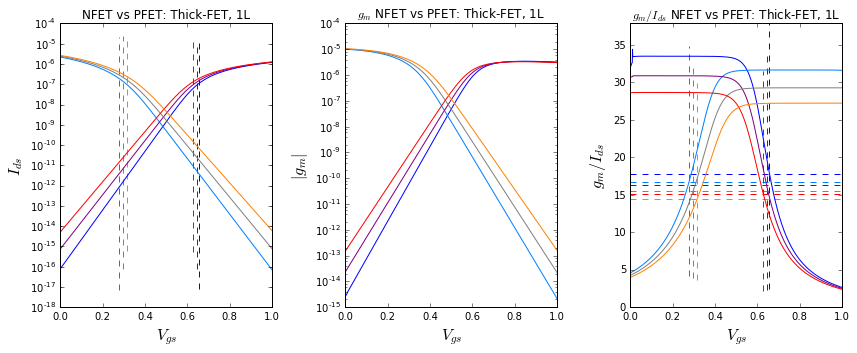

In [39]:
Vths_N_eg1L, IS_N_eg1L, Vths_P_eg1L, IS_P_eg1L = compareFETs(("NFET_eg1L", "PFET_eg1L"), 
            (folderRoot, folderRoot),"NFET vs PFET: Thick-FET, 1L",  curveType="IdsVgsCurve", printFN=False)

Compare $V_{rbb}=-1V$ (typical) vs $V_{rbb}=0V$

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_eg1L ): [0.65600000000000047, 0.64300000000000046, 0.62700000000000045] 
Vth ( NFET_eg1L_vRBB0 ): [0.54400000000000037, 0.52900000000000036, 0.51400000000000035]
IS ( NFET_eg1L ): [1.2822845528991988e-07, 1.4307680420652321e-07, 1.5057694732394919e-07] 
IS ( NFET_eg1L_vRBB0 ): [1.4404540106530499e-07, 1.5623951015701357e-07, 1.6804573859208087e-07]


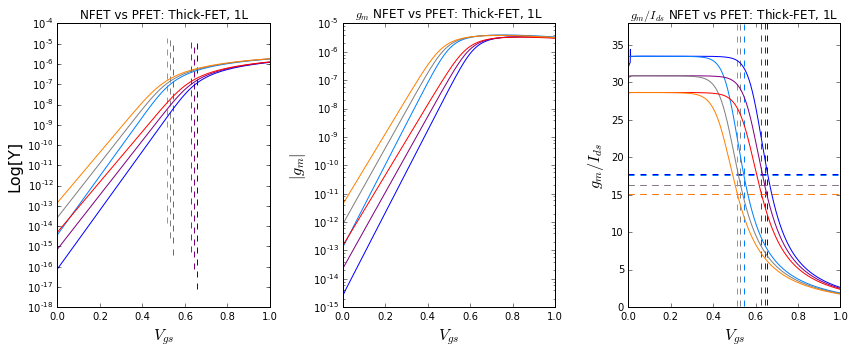

In [113]:
Vths_N_eg1L, IS_N_eg1L, Vths_P_eg1L, IS_P_eg1L = compareFETs(("NFET_eg1L", "NFET_eg1L_vRBB0"), 
            (folderRoot, folderRoot),"NFET vs PFET: Thick-FET, 1L",  curveType="IdsVgsCurve")

#### Compare Multiple FETs

FETType: NFET_eg1L_vRBB-2 Temp: 0.0 	Vds: 0.012
FETType: NFET_eg1L_vRBB-2 Temp: 25.0 	Vds: 0.013
FETType: NFET_eg1L_vRBB-2 Temp: 50.0 	Vds: 0.014
FETType: NFET_eg1L_vRBB-1.5 Temp: 0.0 	Vds: 0.012
FETType: NFET_eg1L_vRBB-1.5 Temp: 25.0 	Vds: 0.013
FETType: NFET_eg1L_vRBB-1.5 Temp: 50.0 	Vds: 0.014
FETType: NFET_eg1L_vRBB-1 Temp: 0.0 	Vds: 0.012
FETType: NFET_eg1L_vRBB-1 Temp: 25.0 	Vds: 0.013
FETType: NFET_eg1L_vRBB-1 Temp: 50.0 	Vds: 0.014
FETType: NFET_eg1L_vRBB-0.5 Temp: 0.0 	Vds: 0.012
FETType: NFET_eg1L_vRBB-0.5 Temp: 25.0 	Vds: 0.013
FETType: NFET_eg1L_vRBB-0.5 Temp: 50.0 	Vds: 0.014
FETType: NFET_eg1L_vRBB0 Temp: 0.0 	Vds: 0.012
FETType: NFET_eg1L_vRBB0 Temp: 25.0 	Vds: 0.013
FETType: NFET_eg1L_vRBB0 Temp: 50.0 	Vds: 0.014
FETType: NFET_eg1L_vRBB0.5 Temp: 0.0 	Vds: 0.012
FETType: NFET_eg1L_vRBB0.5 Temp: 25.0 	Vds: 0.013
FETType: NFET_eg1L_vRBB0.5 Temp: 50.0 	Vds: 0.014
FETType: NFET_eg1L_vRBB1 Temp: 0.0 	Vds: 0.012
FETType: NFET_eg1L_vRBB1 Temp: 25.0 	Vds: 0.013
FETType: NFET_eg1

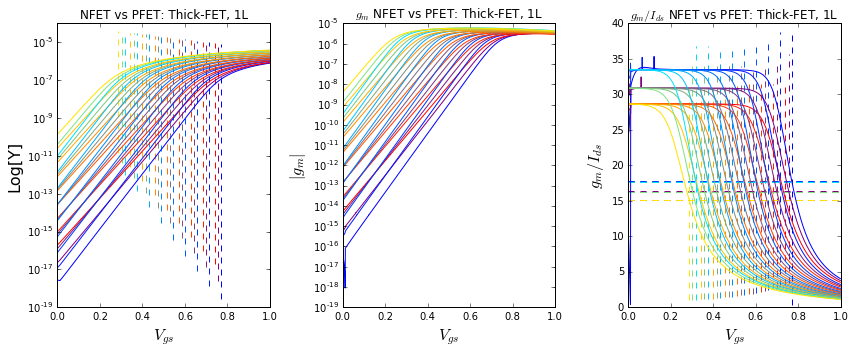

In [265]:
FETTypes = ("NFET_eg1L_vRBB-2", "NFET_eg1L_vRBB-1.5", "NFET_eg1L_vRBB-1", 
            "NFET_eg1L_vRBB-0.5", "NFET_eg1L_vRBB0", "NFET_eg1L_vRBB0.5",
            "NFET_eg1L_vRBB1", "NFET_eg1L_vRBB1.5", "NFET_eg1L_vRBB2")
Vths_eg1L_Vals, IS_eg1L_Vals = compareMultFETs(FETTypes, 
            folderRoot,"NFET vs PFET: Thick-FET, 1L",  curveType="IdsVgsCurve")

Compare where the maximum slope of the gm/Id plot occurs at relative to the threshold voltage.

Temp: 0.0 	Vds: 0.012
/home/noza/work/data/FET_tests/ExtractParams/NFET_eg1L_IdsVgsCurve_Vds0.012.csv
169.794821949
[ 0.628]
Temp: 25.0 	Vds: 0.013
/home/noza/work/data/FET_tests/ExtractParams/NFET_eg1L_IdsVgsCurve_Vds0.013.csv
144.331199018
[ 0.611]
Temp: 50.0 	Vds: 0.014
/home/noza/work/data/FET_tests/ExtractParams/NFET_eg1L_IdsVgsCurve_Vds0.014.csv
124.192839691
[ 0.594]


/opt/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/opt/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/opt/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/opt/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/opt/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/opt/anacon

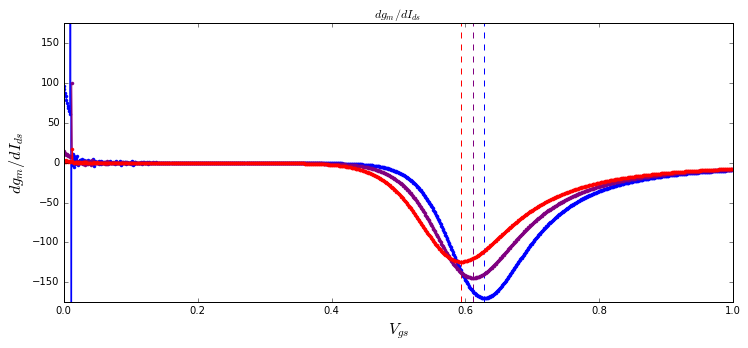

In [104]:
numTemps = len(temps)
for i, curTemp in enumerate(temps):
    Vd = Vds[i]
    #print 
    print "Temp:", curTemp, "\tVds:", Vd    
    Vgsfoo, Idsfoo = getData(folderRoot, FETType="NFET_eg1L",CurveType="IdsVgsCurve", IDVal="Vds"+str(Vd), printFN=True)
    gmsfoo = calcGm(Vgsfoo[:,i], Idsfoo[:,i])
    gmOverIdfoo = calcGmOverId(gmsfoo,Idsfoo[:-1,i])
    col = (1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1)))
    
    derivs = plotDeriv(Vgsfoo[:-1,i],gmOverIdfoo,
              ttl=r'$dg_m/dI_{ds}$ ', xLbl=r'$V_{gs}$', yLbl=r'$d g_m/d I_{ds}$',
              color=col)
    curMaxDeriv = max(abs(derivs[0.1*len(derivs):-0.1*len(derivs)]))
    print curMaxDeriv
    Vth = Vgsfoo[where(abs(derivs)==curMaxDeriv),i][-1]
    print Vth
    yLim = 175
    ylim((-yLim,yLim))
    vlines(Vth, -yLim, yLim, colors=col, linestyles='dashed')


We see from the plot above that the threshold voltage calculated using the approach in S&GM is different from the results gotten using the maximum slope of the $g_m/I_d$ plot.  There is no reason to believe that the maximum slope of gm/Id would result in the correct threshold voltage, but I was curious how closely it would be to the $\frac{max(g_m/I_d)}{2}$ point.

Temp: 0.0 	Vds: 0.012
34.0667009647
Temp: 25.0 	Vds: 0.013
31.3542316266
Temp: 50.0 	Vds: 0.014
29.0546953481


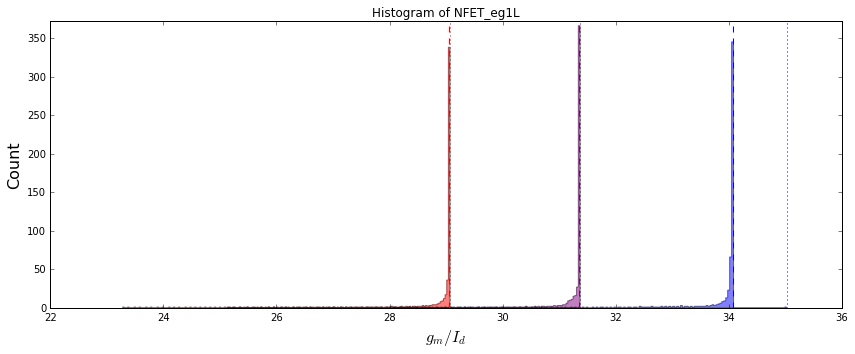

In [275]:
FETType="NFET_eg1L"
getMaxGmOverIdFunc(FETType, folderRoot, ttl="Histogram of "+str(FETType), colorSkew=0)

## Extract $I_{sp}$

TODO: Try to figure out how to connect EKV model with this analysis above, if necessary.   (Figure out how math supports this intersection point

(LP) TODO: Try to extract IS using ID^0.5 plot vs Vs, and extracting slope in SI saturation region.  Compare to this extracted slope.

### Log-steps with $V_{gs}$ varying from 0-1V

Number of FETTypes: 3
FETType: NFET_eg1L_logSteps_vRBB-2_Vgs1 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-2_Vgs1 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-2_Vgs1 Temp: 50.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-1_Vgs1 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-1_Vgs1 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-1_Vgs1 Temp: 50.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB0_Vgs1 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB0_Vgs1 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB0_Vgs1 Temp: 50.0 	Vds: 1
IS ( NFET_eg1L_logSteps_vRBB-2_Vgs1 ): [3.7001281242298469e-07, 3.7579538193493892e-07, 3.8108452998606863e-07]
IS_norm( 0.0 ): 0.000667832673352
IS_norm( 25.0 ): 0.000569292053096
IS_norm( 50.0 ): 0.000491435254366
IS ( NFET_eg1L_logSteps_vRBB-1_Vgs1 ): [4.0082153038735992e-07, 4.1312956320613621e-07, 4.2338991398933727e-07]
IS_norm( 0.0 ): 0.000723439040996
IS_norm( 25.0 ): 0.000625849567447
IS_norm( 50.0 ): 0.000545991016967
IS ( NFET_eg1L_logSte

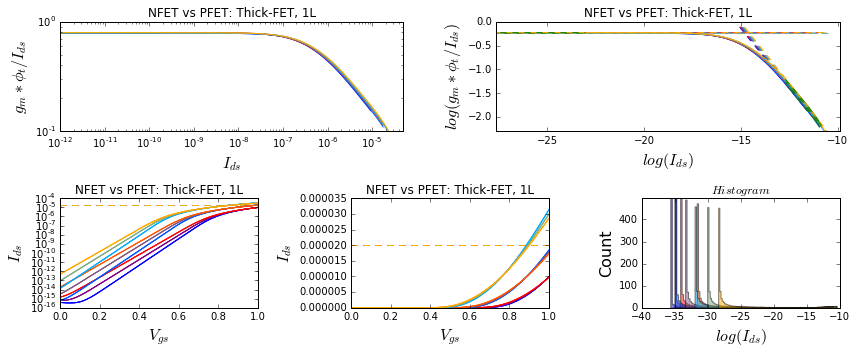

In [193]:
FETTypes = ("NFET_eg1L_logSteps_vRBB-2_Vgs1", "NFET_eg1L_logSteps_vRBB-1_Vgs1", "NFET_eg1L_logSteps_vRBB0_Vgs1")
#FETTypes = (["NFET_eg1L_logSteps_vRBB0"])
ISs = extractIS(FETTypes,
                folderRoot,"NFET vs PFET: Thick-FET, 1L", 
                xLims=(10**-12,5*10**-5), yLims=(1*10**-1,1),
                lBounds=(10**-12,10**-10), uBounds=(3*10**-6,2*10**-5),
                curveType="IdsVgsCurve")

### Log-steps with $V_{gs}$ varying from 0-2V

Number of FETTypes: 3
FETType: NFET_eg1L_logSteps_vRBB-2_Vgs2 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-2_Vgs2 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-2_Vgs2 Temp: 50.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-1_Vgs2 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-1_Vgs2 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB-1_Vgs2 Temp: 50.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB0_Vgs2 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB0_Vgs2 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_logSteps_vRBB0_Vgs2 Temp: 50.0 	Vds: 1
IS ( NFET_eg1L_logSteps_vRBB-2_Vgs2 ): [4.0636817978106048e-07, 4.1844271798775121e-07, 4.2557208808831988e-07]
IS_norm( 0.0 ): 0.000733450136743
IS_norm( 25.0 ): 0.00063389846038
IS_norm( 50.0 ): 0.000548805083661
IS ( NFET_eg1L_logSteps_vRBB-1_Vgs2 ): [4.0002828461983238e-07, 4.1180390246065113e-07, 4.2243827907645025e-07]
IS_norm( 0.0 ): 0.00072200731911
IS_norm( 25.0 ): 0.000623841325292
IS_norm( 50.0 ): 0.00054476381694
IS ( NFET_eg1L_logSteps_

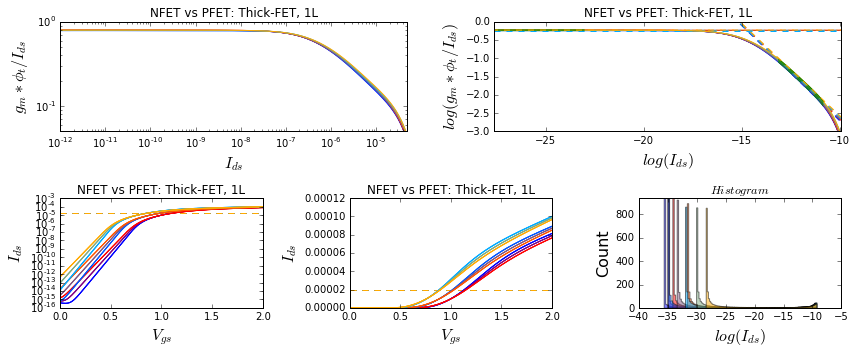

In [195]:
FETTypes = ("NFET_eg1L_logSteps_vRBB-2_Vgs2", "NFET_eg1L_logSteps_vRBB-1_Vgs2", "NFET_eg1L_logSteps_vRBB0_Vgs2")
ISs = extractIS(FETTypes,
                folderRoot,"NFET vs PFET: Thick-FET, 1L", 
                xLims=(10**-12,5*10**-5), yLims=(5*10**-2,1),
                lBounds=(10**-12,10**-10), uBounds=(2*10**-6,2*10**-5),
                curveType="IdsVgsCurve")

### Lin-steps with $V_{gs}$ varying from 0-3V

Number of FETTypes: 3
FETType: NFET_eg1L_linSteps_vRBB-2_Vgs3 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-2_Vgs3 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-2_Vgs3 Temp: 50.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-1_Vgs3 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-1_Vgs3 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB-1_Vgs3 Temp: 50.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB0_Vgs3 Temp: 0.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB0_Vgs3 Temp: 25.0 	Vds: 1
FETType: NFET_eg1L_linSteps_vRBB0_Vgs3 Temp: 50.0 	Vds: 1
IS ( NFET_eg1L_linSteps_vRBB-2_Vgs3 ): [4.2186724010114786e-07, 4.3283858173003709e-07, 4.4174624370498221e-07]
IS_norm( 0.0 ): 0.000761424246127
IS_norm( 25.0 ): 0.000655706740151
IS_norm( 50.0 ): 0.000569662792789
IS ( NFET_eg1L_linSteps_vRBB-1_Vgs3 ): [4.1351606702626272e-07, 4.2586177720837838e-07, 4.3659222811727081e-07]
IS_norm( 0.0 ): 0.00074635129175
IS_norm( 25.0 ): 0.000645137585869
IS_norm( 50.0 ): 0.000563016327866
IS ( NFET_eg1L_linStep

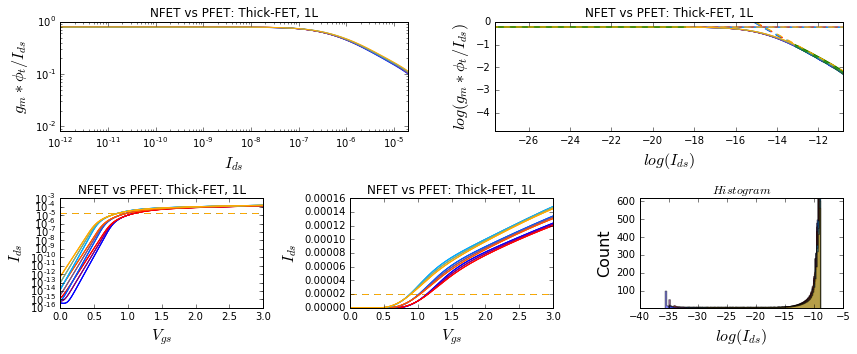

In [196]:
FETTypes = ("NFET_eg1L_linSteps_vRBB-2_Vgs3", "NFET_eg1L_linSteps_vRBB-1_Vgs3", "NFET_eg1L_linSteps_vRBB0_Vgs3")
#FETTypes = (["NFET_eg1L_logSteps_vRBB0"])
ISs = extractIS(FETTypes,
                folderRoot,"NFET vs PFET: Thick-FET, 1L", 
                xLims=(10**-12,2*10**-5), yLims=(8*10**-3,1*10**-0),
                lBounds=(10**-12,10**-8), uBounds=(2*10**-6,2*10**-5),
                curveType="IdsVgsCurve")

## Plot slope factor $n$ ($\frac{1}{\kappa}$)

_Note: the mean, min, and max values shown are for the full measured range of values and not for the region that is being viewed using xLims()_
### Short-channel (150nm)

#### Thick-Oxide SF plots

------------NFET ThickOx 1L------------
Temp:  0.0
Mean SFs: 1.110770098 	Mean kappa: 0.900288097822
Min SFs: 1.0951387453 	Min kappa: 0.894994845349
Max SFs: 1.11732487086 	Max kappa: 0.913126308689
Temp:  25.0
Mean SFs: 1.11108022504 	Mean kappa: 0.900044489998
Min SFs: 1.08419970147 	Min kappa: 0.893959460603
Max SFs: 1.11861895765 	Max kappa: 0.922339305801
Temp:  50.0
Mean SFs: 1.11107138678 	Mean kappa: 0.9000724495
Min SFs: 1.06786367262 	Min kappa: 0.892930460072
Max SFs: 1.11990803844 	Max kappa: 0.936449123272
Fitted Gammas: [ 108.1064104    90.34977704    3.27192659]
Fitted V_fermis: [  1.19523827e+05   8.32744564e+04   1.10916464e+02]
None


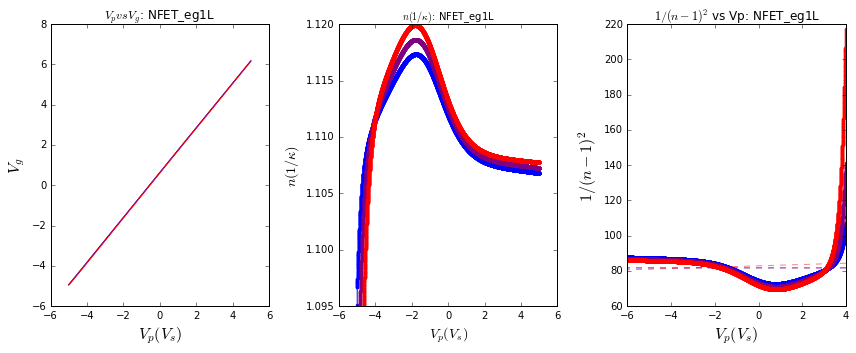

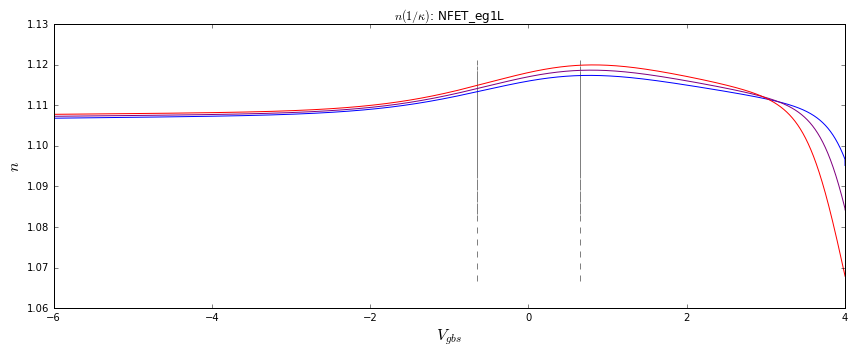

In [105]:
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET_eg1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, ttl="NFET_eg1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------NFET ThickOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
advSFInfo(folderRoot, FETType="NFET_eg1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.108, 1.115),printFN=False, plotIdx=0, Vdd=1, Vth=0.65)

------------PFET ThickOx 1L------------
Temp:  0.0
Mean SFs: 1.12021347223 	Mean kappa: 0.892689759638
Min SFs: 1.11623611783 	Min kappa: 0.889527250204
Max SFs: 1.12419265376 	Max kappa: 0.895867804339
Temp:  25.0
Mean SFs: 1.120423529 	Mean kappa: 0.892522844578
Min SFs: 1.1158566298 	Min kappa: 0.88912749044
Max SFs: 1.12469810095 	Max kappa: 0.896172477088
Temp:  50.0
Mean SFs: 1.12066003255 	Mean kappa: 0.892334943403
Min SFs: 1.11534300286 	Min kappa: 0.888743165693
Max SFs: 1.12518446116 	Max kappa: 0.896585173739
Fitted Gammas: [ 82.40444626  84.97409562  87.66593766]
Fitted V_fermis: [ 58778.50031023  62291.59253815  66049.31492752]
None


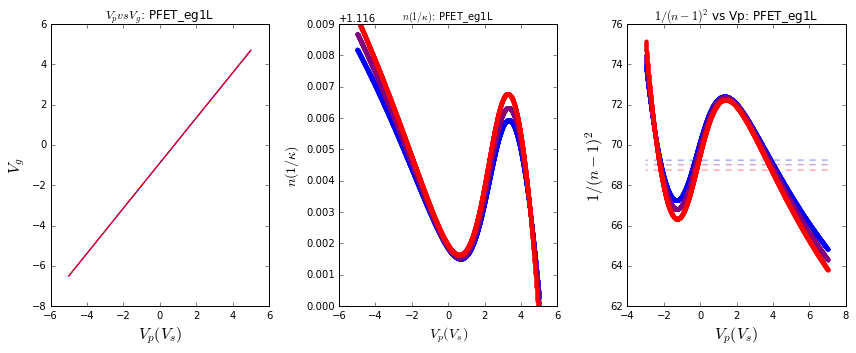

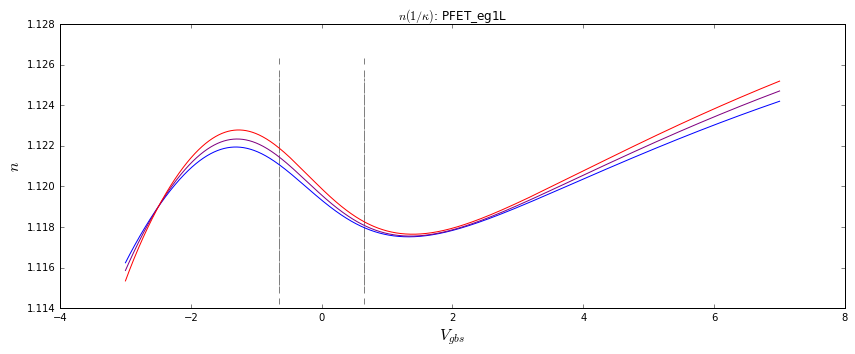

In [106]:
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="PFET_eg1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, ttl="PFET_eg1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------PFET ThickOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
advSFInfo(folderRoot, FETType="PFET_eg1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.108, 1.115),printFN=False, plotIdx=0, Vdd=1, Vth=0.65)

# Appendix

## Test  plotting of slope factors and extracting parameters

### Using actual data

/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T0C.csv
Fitted Gamma: 0.845006695541 	 Fitted V_fermi: 7.13066949677
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T25C.csv
Fitted Gamma: 0.818758900172 	 Fitted V_fermi: 6.61675430316
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T50C.csv
Fitted Gamma: 0.800330513411 	 Fitted V_fermi: 6.24774072095


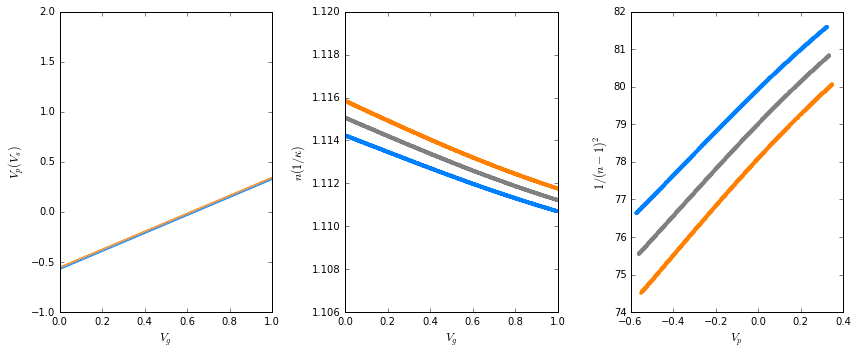

In [794]:
#from scipy.optimize import least_squares
FETType = "NFET"
curveType = "VgvsVs_KappaExtraction"
for i, curTemp in enumerate(temps):
    j=1
    Vps, Vgs = getData(folderRoot, FETType=FETType,
                                            CurveType=curveType, IDVal="T"+str(int(curTemp))+"C", printFN=True)
    subplot(1,3,1)
    #plotVpvsVg((Vgs[mask[:,i],2], Vps[mask[:,i],i]))
    plotVpvsVg((Vgs[:,2], Vps[:,i]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    xlim((0,1))
    subplot(1,3,2)
    SFs = plotSlopeFactor((Vgs[:,2], Vps[:,i]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    xlim((0,1))
    subplot(1,3,3)
    mask = where((Vgs[:,2]>=0)*(Vgs[:,2]<1))[0]
    #print "AAA", len(mask), mask
    #print "BBB", len(Vps[mask,i]), Vps[mask,i]
    #print "CCC", len(SFs[mask]), min(SFs[mask]), max(SFs[mask])
    gamma, vFermi = getSFParams(Vps[mask,i], calcInvNOffSq(SFs)[mask], (0.5, 0.2))
    invNOffSq = plotSFParamData((Vps[mask,i], SFs[mask]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    #print invNOffSq
    #gamma, vFermi = getSFParams(Vps[mask,i], invNOffSq, (0.201, -10.1))
tight_layout()

### Using fabricated data

In [96]:
fooVgs = linspace(0,1,101)
fooVps = 0.9*(fooVgs-0.5)
#bar = linspace(1.1, 1.05, 101)
#print fooVgs, fooVps

# This is fake data testing to see if the leastsq algorithm is working
fooInvNSq = SFParamEq(fooVps, 0.5, 0.325)
#print "invNOffSq:", fooInvNSq
noise = np.random.normal(0,1,101)
#print noise
#print fooInvNSq+noise
noisyInvNOffSq = fooInvNSq+noise

#print ((1./fooInvNSq)**0.5)+1
fooGamma, fooFermiV = getSFParams(fooVps, noisyInvNOffSq, (0.5, 0.2))
print fooGamma, fooFermiV

0.505639704987 0.331551161409


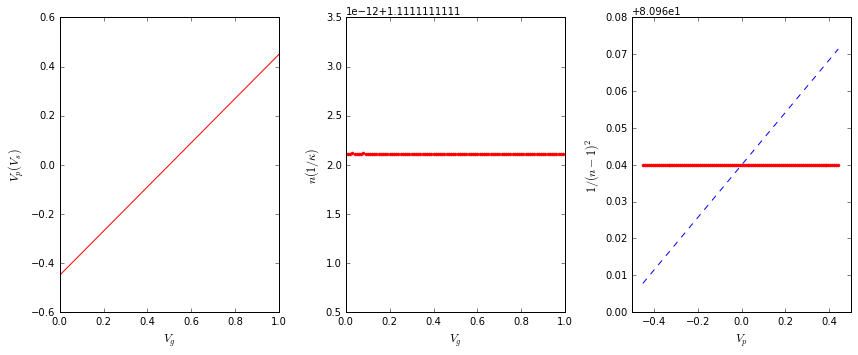

In [98]:
subplot(1,3,1)
plotVpvsVg((fooVgs, fooVps))
subplot(1,3,2)
fooSFs = plotSlopeFactor((fooVgs, fooVps))
#print fooSFs
subplot(1,3,3)
fooInvNSqs = plotSFParamData((fooVps[:-1], fooSFs))
#print fooInvNSqs
fooGamma, fooFermiV = getSFParams(fooVps[:-1], fooInvNSqs, (0.04, 0.3))
#print fooGamma, fooFermiV
#print SFParamEq(fooVps[:-1], fooGamma, fooFermiV)
plot(fooVps[:-1],SFParamEq(fooVps[:-1], fooGamma, fooFermiV),'--')

tight_layout()

## Test getIVal and getVVal methods

In [443]:
for a in arange(3):
    curveType = "IdsVgsCurve"
    FETType = "PFET_eg1L"
    xVals, yVals = getData(folderRoot_P, FETType=FETType,
                                            CurveType=curveType, IDVal="Vds"+str(Vds[a]))

    print IS_P_eg1L[a]/1.13, IS_P_eg1L[a], temps[a], Vds[a]
    Vgs = getVVal(IS_P_eg1L[a]/1.13, xVals[:,a], yVals[:,a])
    Id = getIVal(Vgs, xVals[:,a], yVals[:,a])
    print Vgs, Id*1.13

#    FETType = "NFET_eg1L"
#    xVals, yVals = getData(folderRoot, FETType=FETType,
#                                            CurveType=curveType, IDVal="Vds"+str(Vds[a]))
#    print IS_N_eg1L[a]/1.13, IS_N_eg1L[a], temps[a], Vds[a]
#    Vgs = getVVal(array(IS_N_eg1L[a])/1.13, xVals[:,a], yVals[:,a])
#    Id = getIVal(Vgs, xVals[:,a], yVals[:,a])
#    print Vgs, Id

/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.012.csv
2.7455856672e-08 3.10251180393e-08 0.0 0.012
0.312 3.10251180393e-08
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.013.csv
3.06940287421e-08 3.46842524786e-08 25.0 0.013
0.334 3.46842524786e-08
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.014.csv
3.36264050904e-08 3.79978377521e-08 50.0 0.014
0.356 3.79978377521e-08


## Print permutations of Vds and temp sweeps to get all values
Print all permutations of Vds and temp sweeps to ensure I'm grabbing the correct values from my CompareFETs sweep

Note: I am!! :-D

[0.65600000000000047, 0.64300000000000046, 0.62700000000000045]
[1.2822845528991988e-07, 1.4307680420652321e-07, 1.5057694732394919e-07]
Vd: 0.012
Temp: 0.0
Vt( 0.0 ):  0.278
IS( 0.0 ):  1.92650471573e-07 2.17695032878e-07
Temp: 25.0
Vt( 25.0 ):  0.298
IS( 25.0 ):  2.0956264187e-07 2.36805785313e-07
Temp: 50.0
Vt( 50.0 ):  0.318
IS( 50.0 ):  2.23667511767e-07 2.52744288297e-07


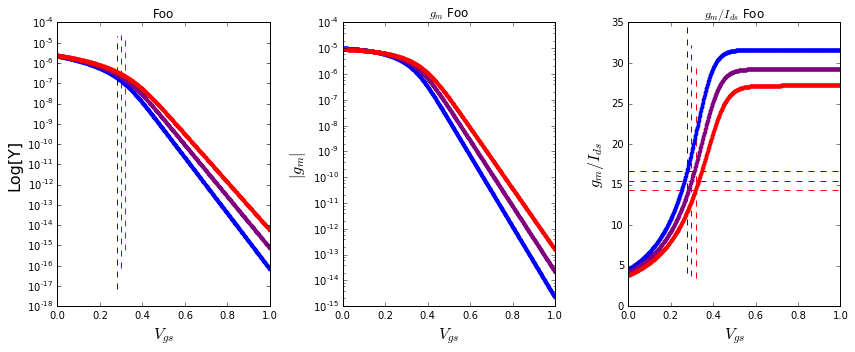

Vd: 0.013
Temp: 0.0
Vt( 0.0 ):  0.277
IS( 0.0 ):  1.98728930266e-07 2.245636912e-07
Temp: 25.0
Vt( 25.0 ):  0.297
IS( 25.0 ):  2.16210643126e-07 2.44318026732e-07
Temp: 50.0
Vt( 50.0 ):  0.317
IS( 50.0 ):  2.30892196767e-07 2.60908182347e-07


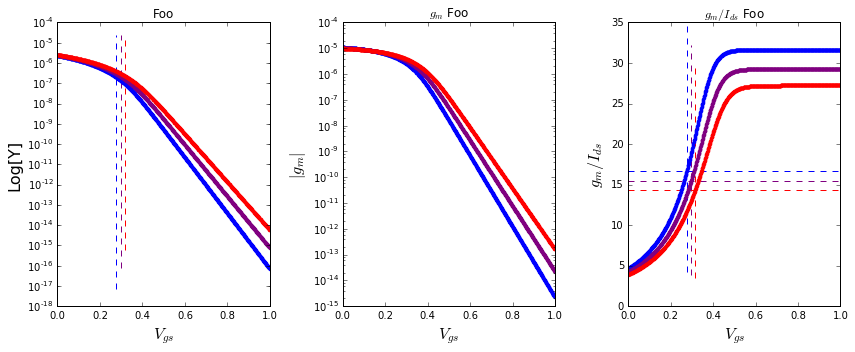

Vd: 0.014
Temp: 0.0
Vt( 0.0 ):  0.276
IS( 0.0 ):  2.04552905566e-07 2.3114478329e-07
Temp: 25.0
Vt( 25.0 ):  0.296
IS( 25.0 ):  2.22497434411e-07 2.51422100884e-07
Temp: 50.0
Vt( 50.0 ):  0.316
IS( 50.0 ):  2.3764604299e-07 2.68540028578e-07


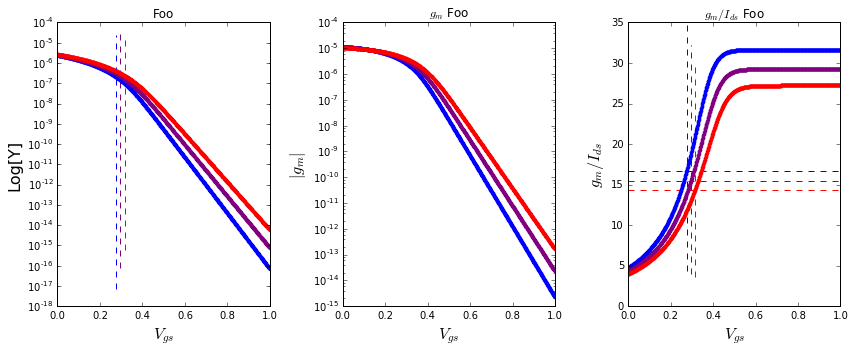

In [120]:
print Vths_N_eg1L
print IS_N_eg1L
FETType = "PFET_eg1L"
curveType = "IdsVgsCurve"


for j, Vd in enumerate(Vds):
    print "Vd:", Vd
    xVals, yVals = getData(folderRoot, FETType=FETType,
                                            CurveType=curveType, IDVal="Vds"+str(Vd))
    numTemps = shape(yVals)[1]
    for i, temp in enumerate(temps):
        print "Temp:", temp
        curVgs = xVals[:,i]
        curIds = yVals[:,i]
        #print curIds
        curGms = calcGm(curVgs, curIds)
        #print curGms
        curGmOverId = calcGmOverId(curGms, elementWiseAvg(curIds))
        #print calcGmOverId(curGms, curIds[:-1])
        
        Vth, halfGmOverId  = calcVth(curVgs, curGmOverId)
        print "Vt(", temp,"): ", Vth
        curIS = calcIS(Vth, curVgs, curIds)[0]
        print "IS(",temp,"): ", curIS/1.13, curIS
        a, b, c, d = plotVgPlots(curVgs, curIds, "Foo", 
                    color=(1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1))))
    show()

## Fit the subthreshold region for parameters

In [ ]:
temp = 25
print Vds
print xData
print yData

popt, pcov = leastsq(Ids_NFET_Err, (0.7, 0.6, -9, 0.05), args=(xData, yData, Vds, temp))
kappa = popt[0]
gam = popt[1]
Kd = popt[2]
lamda = popt[3]